In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    recall_score,
    precision_score,
    fbeta_score,
    roc_curve,
    auc,
    precision_recall_curve
)
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns

!pip install optuna shap
import optuna
import shap


##  2-CLASS DATA PREP FOR ANN


In [ ]:
from google.colab import files

uploaded = files.upload()

df_1 = pd.read_csv('bcsc_risk_factors_summarized1_092020.csv')
df_2 = pd.read_csv('bcsc_risk_factors_summarized2_092020.csv')
df_3 = pd.read_csv('bcsc_risk_factors_summarized3_092020.csv')

# Concatenate
df = pd.concat([df_1, df_2, df_3], ignore_index=True)
print("Raw shape:", df.shape)

# DROP COLUMNS "year" and "count"
df = df.drop(columns=['year', 'count'])
print("After dropping year & count:", df.shape)

# Make everything categorical
df = df.astype('category')

# Replace 9 with NaN in all columns EXCEPT age_group_5_years
cols_except_age = df.columns[df.columns != 'age_group_5_years']
df[cols_except_age] = df[cols_except_age].replace(9, np.nan)

# Drop rows where target (breast_cancer_history) is NaN
df = df.dropna(subset=['breast_cancer_history'])

df = df[df['breast_cancer_history'].isin([0, 1])].copy()

missing_info = pd.DataFrame({
    'Missing Count': df.isna().sum(),
    'Missing %': (df.isna().sum() / len(df)) * 100
})
print("\nMissing info:")
print(missing_info)

# Fill NaN in each remaining column with the mode (except target)
for col in df.columns:
    if col != 'breast_cancer_history':
        df[col].fillna(df[col].mode()[0], inplace=True)

print("\nShape after filling NaNs:", df.shape)

# One-hot encoding for race_eth
df = pd.get_dummies(df, columns=['race_eth'], drop_first=True)

# Convert any bool columns to int
bool_cols = df.select_dtypes('bool').columns
df[bool_cols] = df[bool_cols].astype(int)

print("\nDtypes after get_dummies and bool→int:")
print(df.dtypes.head(15))

# 11) Define X and y for 2-class ANN
target_col = 'breast_cancer_history'

# y = binary labels 0/1
y = df[target_col].astype('int32')

# X = all other columns
X = df.drop(columns=[target_col])

X = X.astype('float32')

print("\nFinal X shape:", X.shape)
print("Final y value counts:")
print(y.value_counts())




Saving bcsc_risk_factors_summarized1_092020.csv to bcsc_risk_factors_summarized1_092020.csv
Saving bcsc_risk_factors_summarized3_092020.csv to bcsc_risk_factors_summarized3_092020.csv
Saving bcsc_risk_factors_summarized2_092020.csv to bcsc_risk_factors_summarized2_092020.csv
Raw shape: (1522340, 13)
After dropping year & count: (1522340, 11)


/tmp/ipython-input-2700931115.py:22: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df[cols_except_age] = df[cols_except_age].replace(9, np.nan)



Missing info:
                       Missing Count  Missing %
age_group_5_years                  0   0.000000
race_eth                       74699   6.269651
first_degree_hx                37109   3.114640
age_menarche                  529232  44.419601
age_first_birth               234599  19.690408
BIRADS_breast_density         144193  12.102434
current_hrt                   124688  10.465337
menopaus                      105394   8.845949
bmi_group                     309681  25.992204
biophx                         22425   1.882179
breast_cancer_history              0   0.000000

Shape after filling NaNs: (1191438, 11)


/tmp/ipython-input-2700931115.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)



Dtypes after get_dummies and bool→int:
age_group_5_years        category
first_degree_hx          category
age_menarche             category
age_first_birth          category
BIRADS_breast_density    category
current_hrt              category
menopaus                 category
bmi_group                category
biophx                   category
breast_cancer_history    category
race_eth_2                  int64
race_eth_3                  int64
race_eth_4                  int64
race_eth_5                  int64
race_eth_6                  int64
dtype: object

Final X shape: (1191438, 14)
Final y value counts:
breast_cancer_history
0    969662
1    221776
Name: count, dtype: int64


Train shape: (762520, 14)  Val shape: (190630, 14)  Test shape: (238288, 14)


[I 2025-12-08 16:07:28,703] A new study created in memory with name: no-name-da390a16-83d9-4671-aa9e-28c9ea7961c5


Class weights: {0: 0.6143577893690289, 1: 2.6861213073405805}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-12-08 16:09:44,402] Trial 0 finished with value: 0.6443493973758702 and parameters: {'n_units1': 96, 'n_units2': 16, 'dropout1': 0.16631400553650177, 'dropout2': 0.26415830806324714, 'batch_size': 256}. Best is trial 0 with value: 0.6443493973758702.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-12-08 16:11:45,335] Trial 1 finished with value: 0.6401655561367202 and


Best trial: 7
Best value (F2): 0.6449670751539603
Best params: {'n_units1': 64, 'n_units2': 16, 'dropout1': 0.38221375235430255, 'dropout2': 0.45541845098357603, 'batch_size': 512}
Epoch 1/200
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5671 - auc_pr: 0.2220 - auc_roc: 0.5556 - loss: 0.7147 - precision: 0.2138 - recall: 0.4996 - val_accuracy: 0.6098 - val_auc_pr: 0.3668 - val_auc_roc: 0.7367 - val_loss: 0.6431 - val_precision: 0.2940 - val_recall: 0.7825
Epoch 2/200
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6274 - auc_pr: 0.3233 - auc_roc: 0.6989 - loss: 0.6308 - precision: 0.2877 - recall: 0.6753 - val_accuracy: 0.6570 - val_auc_pr: 0.4125 - val_auc_roc: 0.7846 - val_loss: 0.5822 - val_precision: 0.3296 - val_recall: 0.8150
Epoch 3/200
1490/1490 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6645 - auc_pr: 0.3703 - auc_roc: 0.7527 - loss: 0.5891 - precision: 0.3254 - recall: 0.7492 - val_accuracy: 0.6721 - val_auc_pr: 0.4202 - val_auc_roc: 0.7923 - val_los

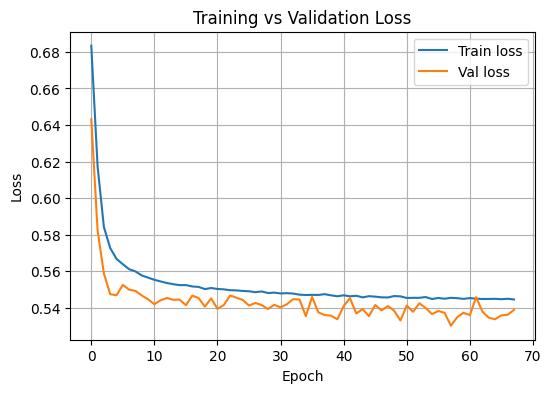

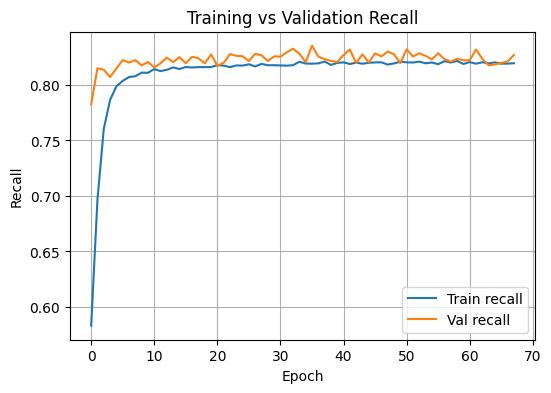

In [ ]:
# ANN + OPTUNA (BINARY VERSION)

# Split: Train / Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

print("Train shape:", X_tr.shape, " Val shape:", X_val.shape, " Test shape:", X_test.shape)

# Class weights (for recall / Type II error)
classes = np.unique(y_tr)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr)
class_weight = {int(c): float(w) for c, w in zip(classes, cw)}
print("Class weights:", class_weight)

input_dim = X_tr.shape[1]

# 5) OPTUNA: objective function
def objective(trial):
    tf.keras.backend.clear_session()

    # Hyperparameters
    n_units1 = trial.suggest_int("n_units1", 32, 96, step=32)
    n_units2 = trial.suggest_int("n_units2", 16, 48, step=16)
    dropout1 = trial.suggest_float("dropout1", 0.1, 0.5)
    dropout2 = trial.suggest_float("dropout2", 0.1, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [128, 256, 512])

    lr = 0.0001

    # Build model
    model_tmp = Sequential([
        Dense(n_units1, activation='relu', input_dim=input_dim),
        Dropout(dropout1),
        Dense(n_units2, activation='relu'),
        Dropout(dropout2),
        Dense(1, activation='sigmoid')  # binary classification
    ])

    optimizer = Adam(learning_rate=lr)

    model_tmp.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.Recall(name='recall')]
    )

    early_stop_opt = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Train candidate model
    history_tmp = model_tmp.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=batch_size,
        callbacks=[early_stop_opt],
        class_weight=class_weight,
        verbose=0
    )

    # Evaluate
    y_proba_val_tmp = model_tmp.predict(X_val, verbose=0).ravel()
    y_hat_val_tmp = (y_proba_val_tmp >= 0.5).astype(int)

    f2 = fbeta_score(y_val, y_hat_val_tmp, beta=2, zero_division=0)

    return f2

# Optuna search
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("\nBest trial:", study.best_trial.number)
print("Best value (F2):", study.best_value)
print("Best params:", study.best_params)

best_params = study.best_params

# Build the model using Optuna params
tf.keras.backend.clear_session()

model = Sequential([
    Dense(best_params["n_units1"], activation='relu', input_dim=input_dim),
    Dropout(best_params["dropout1"]),
    Dense(best_params["n_units2"], activation='relu'),
    Dropout(best_params["dropout2"]),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.AUC(name='auc_roc'),
        tf.keras.metrics.AUC(name='auc_pr', curve='PR')
    ]
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train model
history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=best_params["batch_size"],
    callbacks=[early_stop],
    class_weight=class_weight,
    verbose=1
)


# PLOTS

# Loss
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Recall
plt.figure(figsize=(6,4))
plt.plot(history.history['recall'], label='Train recall')
plt.plot(history.history['val_recall'], label='Val recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Training vs Validation Recall')
plt.legend()
plt.grid(True)
plt.show()

5958/5958 ━━━━━━━━━━━━━━━━━━━━ 6s 948us/step

Threshold tuning on VALIDATION set:
thr	Recall	Precision	F2
0.10	0.987	0.227		0.592
0.15	0.976	0.247		0.614
0.20	0.961	0.265		0.630
0.25	0.946	0.281		0.642
0.30	0.931	0.295		0.650
0.35	0.910	0.309		0.655
0.40	0.886	0.322		0.656
0.45	0.858	0.335		0.654
0.50	0.821	0.353		0.649
0.55	0.766	0.375		0.634
0.60	0.683	0.404		0.600
0.65	0.604	0.428		0.558
0.70	0.486	0.458		0.481
0.75	0.261	0.504		0.289
0.80	0.062	0.550		0.075
0.85	0.000	0.000		0.000
0.90	0.000	0.000		0.000

Best VALIDATION threshold by F2: {'thr': np.float64(0.4), 'rec': 0.8856667793935294, 'prec': 0.32174740980384126, 'f2': 0.6557893594644676}

=== VALIDATION RESULTS (thr = 0.40) ===
Confusion matrix (VAL):
 [[88897 66249]
 [ 4057 31427]]
Validation accuracy: 0.6312
Validation classification report:
              precision    recall  f1-score   support

           0       0.96      0.57      0.72    155146
           1       0.32      0.89      0.47     35484

    accuracy          

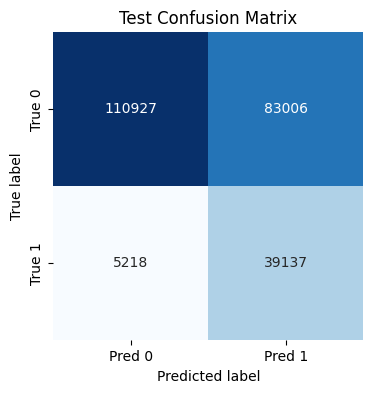

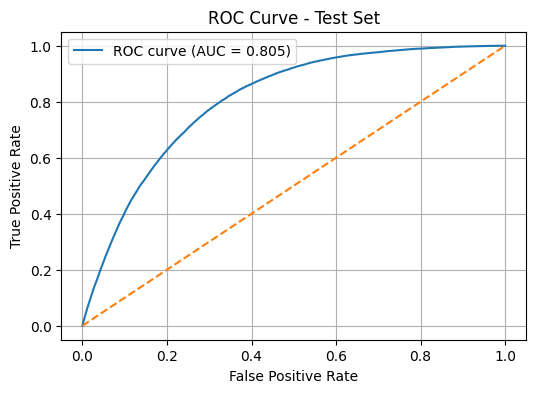

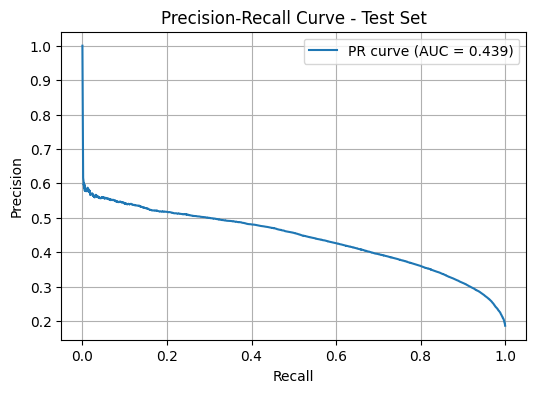

In [ ]:
# Validation:

y_proba_val = model.predict(X_val).ravel()

thresholds = np.linspace(0.1, 0.9, 17)
print("\nThreshold tuning on VALIDATION set:")
print("thr\tRecall\tPrecision\tF2")

best_thr_info = {"thr": None, "rec": -1, "prec": -1, "f2": -1}

for t in thresholds:
    y_hat_val = (y_proba_val >= t).astype(int)
    rec = recall_score(y_val, y_hat_val, zero_division=0)
    prec = precision_score(y_val, y_hat_val, zero_division=0)
    f2 = fbeta_score(y_val, y_hat_val, beta=2, zero_division=0)

    print(f"{t:.2f}\t{rec:.3f}\t{prec:.3f}\t\t{f2:.3f}")

    if f2 > best_thr_info["f2"]:
        best_thr_info = {"thr": t, "rec": rec, "prec": prec, "f2": f2}

best_thr = best_thr_info["thr"]
print("\nBest VALIDATION threshold by F2:", best_thr_info)

# metrics
y_hat_val_best = (y_proba_val >= best_thr).astype(int)

cm_val = confusion_matrix(y_val, y_hat_val_best)
val_acc = (y_hat_val_best == y_val).mean()

print(f"\n=== VALIDATION RESULTS (thr = {best_thr:.2f}) ===")
print("Confusion matrix (VAL):\n", cm_val)
print(f"Validation accuracy: {val_acc:.4f}")
print("Validation classification report:")
print(classification_report(y_val, y_hat_val_best))

# TEST SET:

y_proba_test = model.predict(X_test).ravel()
y_hat_test = (y_proba_test >= best_thr).astype(int)

cm_test = confusion_matrix(y_test, y_hat_test)
tn, fp, fn, tp = cm_test.ravel()
test_recall = tp / (tp + fn + 1e-12)
fnr = 1 - test_recall
test_acc = (y_hat_test == y_test).mean()

print(f"\n=== TEST RESULTS (thr = {best_thr:.2f}) ===")
print("Confusion matrix (TEST):\n", cm_test)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test recall: {test_recall:.4f}")
print(f"Test Type II error (FNR): {fnr:.4f}")
print("Test classification report:")
print(classification_report(y_test, y_hat_test))

# CONFUSION MATRIX HEATMAP (TEST)

plt.figure(figsize=(4,4))
sns.heatmap(cm_test,
            annot=True,
            fmt="d",
            cmap="Blues",
            cbar=False,
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['True 0', 'True 1'])
plt.title('Test Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#ROC CURVE (TEST)

fpr, tpr, _ = roc_curve(y_test, y_proba_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend()
plt.grid(True)
plt.show()

# PRECISION-RECALL CURVE (TEST)

precisions, recalls, _ = precision_recall_curve(y_test, y_proba_test)
pr_auc = auc(recalls, precisions)

plt.figure(figsize=(6,4))
plt.plot(recalls, precisions, label=f'PR curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Test Set')
plt.legend()
plt.grid(True)
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
12975/12975 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
12975/12975 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
12975/12975 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
12975/12975 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
12975/12975 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
12975/12975 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
12975/12975 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
12975/12975 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
12975/12975 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
12975/12975 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
12975/12975 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
12975/12975 ━━━━━━━━━━━━━━━━━━━━ 14s 1

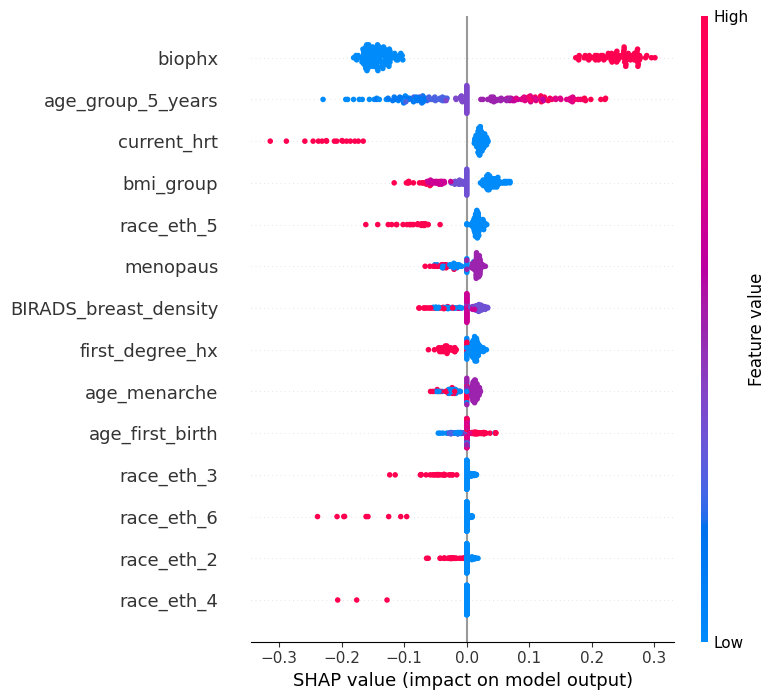

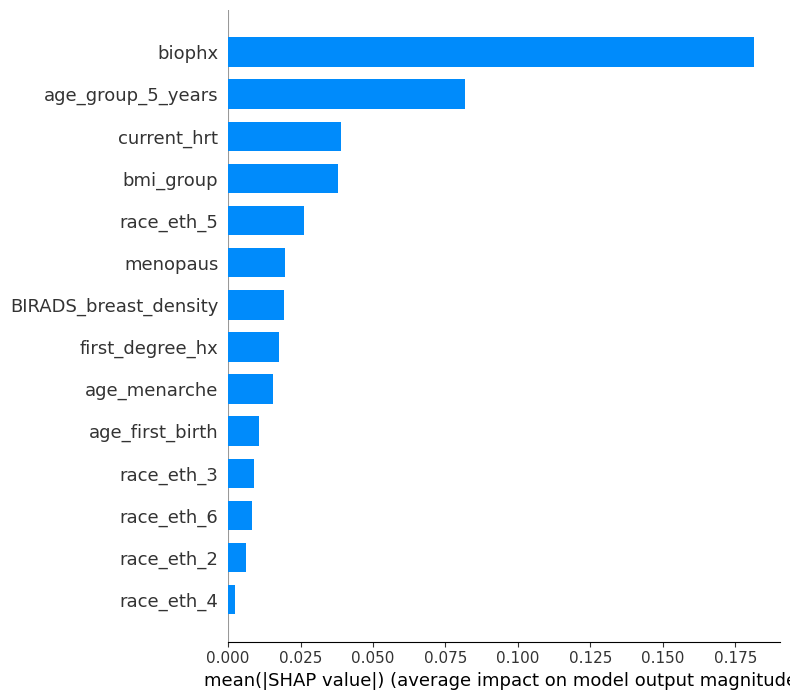

In [ ]:
# 2-CLASS EXPLAINABILITY: SHAP

background_2c = X_tr.sample(200, random_state=42)

explainer_2c = shap.KernelExplainer(
    model.predict,
    background_2c.values
)

X_val_sample_2c = X_val.sample(200, random_state=42)

shap_values_raw = explainer_2c.shap_values(X_val_sample_2c.values)

if isinstance(shap_values_raw, list):
    shap_values_raw = shap_values_raw[0]

if shap_values_raw.ndim == 3 and shap_values_raw.shape[2] == 1:
    shap_values_2c = shap_values_raw[:, :, 0]
else:
    shap_values_2c = shap_values_raw

# SHAP plot
shap.summary_plot(
    shap_values_2c,
    X_val_sample_2c,
    feature_names=X_val_sample_2c.columns
)

# SHAP bar plot
shap.summary_plot(
    shap_values_2c,
    X_val_sample_2c,
    feature_names=X_val_sample_2c.columns,
    plot_type="bar"
)


In [ ]:
print(X.shape)
print(X_val_sample_2c.shape)
print(shap_values_2c.shape)
print(X.dtypes.head(20))


(1191438, 14)
(200, 14)
(200, 14)
age_group_5_years        float32
first_degree_hx          float32
age_menarche             float32
age_first_birth          float32
BIRADS_breast_density    float32
current_hrt              float32
menopaus                 float32
bmi_group                float32
biophx                   float32
race_eth_2               float32
race_eth_3               float32
race_eth_4               float32
race_eth_5               float32
race_eth_6               float32
dtype: object


## 3 Classes - ANN

In [ ]:

uploaded = files.upload()

df_1 = pd.read_csv('bcsc_risk_factors_summarized1_092020.csv')
df_2 = pd.read_csv('bcsc_risk_factors_summarized2_092020.csv')
df_3 = pd.read_csv('bcsc_risk_factors_summarized3_092020.csv')

df = pd.concat([df_1, df_2, df_3], ignore_index=True)

df = df.drop(columns=['year', 'count'])
df = df.astype('category')

cols_except_age = df.columns[df.columns != 'age_group_5_years']
df[cols_except_age] = df[cols_except_age].replace(9, np.nan)

df = df.dropna(subset=['breast_cancer_history'])

# Fill NaNs with mode
for col in df.columns:
    if col != 'breast_cancer_history':
        df[col].fillna(df[col].mode()[0], inplace=True)

# One-hot encoding (race only)
df = pd.get_dummies(df, columns=['race_eth'], drop_first=True)

# Convert bools to ints
bool_cols = df.select_dtypes('bool').columns
df[bool_cols] = df[bool_cols].astype(int)

# Logistic regression to build borderline class
y_bin = df['breast_cancer_history'].astype('int32')
X_logit = df.drop(columns=['breast_cancer_history'])

logit = LogisticRegression(max_iter=5000)
logit.fit(X_logit, y_bin)

df['pred_prob'] = logit.predict_proba(X_logit)[:, 1]

df['breast_cancer_history_3class'] = y_bin.copy()

lower = 0.30
upper = 0.50

mask2 = (
    (df['breast_cancer_history_3class'] == 0) &
    (df['pred_prob'] >= lower) &
    (df['pred_prob'] <= upper)
)

df.loc[mask2, 'breast_cancer_history_3class'] = 2

df_model = df.drop(columns=['breast_cancer_history', 'pred_prob'])

y = df_model['breast_cancer_history_3class'].astype('int32')
X = df_model.drop(columns=['breast_cancer_history_3class']).astype('float32')

print("Final X:", X.shape)
print("Final y:", y.value_counts())


Saving bcsc_risk_factors_summarized1_092020.csv to bcsc_risk_factors_summarized1_092020 (1).csv
Saving bcsc_risk_factors_summarized3_092020.csv to bcsc_risk_factors_summarized3_092020 (1).csv
Saving bcsc_risk_factors_summarized2_092020.csv to bcsc_risk_factors_summarized2_092020 (1).csv


/tmp/ipython-input-4278287959.py:13: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df[cols_except_age] = df[cols_except_age].replace(9, np.nan)
/tmp/ipython-input-4278287959.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


Final X: (1191438, 14)
Final y: breast_cancer_history_3class
0    843140
1    221776
2    126522
Name: count, dtype: int64


In [ ]:
# 3-Class Optuna

# Splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

classes = np.unique(y_tr)
class_weight = {int(c): w for c, w in zip(
    classes,
    compute_class_weight(class_weight='balanced', classes=classes, y=y_tr)
)}

input_dim = X_tr.shape[1]
n_classes = len(classes)

def objective(trial):
    tf.keras.backend.clear_session()

    n1 = trial.suggest_int("n1", 64, 256, step=64)
    n2 = trial.suggest_int("n2", 32, 128, step=32)
    d1 = trial.suggest_float("d1", 0.1, 0.5)
    d2 = trial.suggest_float("d2", 0.1, 0.5)
    bs = trial.suggest_categorical("bs", [128, 256, 512])

    model = Sequential([
        Dense(n1, activation='relu', input_dim=input_dim),
        Dropout(d1),
        Dense(n2, activation='relu'),
        Dropout(d2),
        Dense(n_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    es = EarlyStopping(monitor='val_loss', patience=5,
                       restore_best_weights=True)

    model.fit(X_tr, y_tr,
              validation_data=(X_val, y_val),
              epochs=100,
              batch_size=bs,
              callbacks=[es],
              class_weight=class_weight,
              verbose=0)

    y_val_pred = model.predict(X_val, verbose=0).argmax(axis=1)

    return recall_score(y_val, y_val_pred,
                        average='macro',
                        zero_division=0)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

best_params = study.best_params
print(best_params)


[I 2025-12-08 17:53:23,770] A new study created in memory with name: no-name-645e2597-3502-4220-95a3-4e433a007da5
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-12-08 17:57:10,285] Trial 0 finished with value: 0.7264462024619346 and parameters: {'n1': 64, 'n2': 96, 'd1': 0.17830191185498745, 'd2': 0.18827474784038178, 'bs': 256}. Best is trial 0 with value: 0.7264462024619346.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwarg

{'n1': 128, 'n2': 64, 'd1': 0.41857198485773683, 'd2': 0.35846838036953566, 'bs': 128}


In [ ]:
tf.keras.backend.clear_session()

model = Sequential([
    Dense(best_params["n1"], activation='relu', input_dim=input_dim),
    Dropout(best_params["d1"]),
    Dense(best_params["n2"], activation='relu'),
    Dropout(best_params["d2"]),
    Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=best_params["bs"],
    callbacks=[es],
    class_weight=class_weight,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
5958/5958 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.5487 - loss: 1.0098 - val_accuracy: 0.7299 - val_loss: 0.6059
Epoch 2/200
5958/5958 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.7256 - loss: 0.6953 - val_accuracy: 0.7405 - val_loss: 0.5507
Epoch 3/200
5958/5958 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.7382 - loss: 0.6418 - val_accuracy: 0.7480 - val_loss: 0.5274
Epoch 4/200
5958/5958 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.7429 - loss: 0.6147 - val_accuracy: 0.7477 - val_loss: 0.5121
Epoch 5/200
5958/5958 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.7449 - loss: 0.5974 - val_accuracy: 0.7372 - val_loss: 0.5133
Epoch 6/200
5958/5958 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.7448 - loss: 0.5876 - val_accuracy: 0.7605 - val_loss: 0.4882
Epoch 7/200
5958/5958 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.7451 - loss: 0.5825 - val_accuracy: 0.7455 - val_loss: 0.5024
Epoch 8/200
5958/5958 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.7445 -

In [ ]:
# Validation
y_val_pred = model.predict(X_val).argmax(axis=1)
print("VAL REPORT")
print(classification_report(y_val, y_val_pred))
print(confusion_matrix(y_val, y_val_pred))

# Test
y_test_proba = model.predict(X_test)
y_test_pred = y_test_proba.argmax(axis=1)

print("TEST REPORT")
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))


5958/5958 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
VAL REPORT
              precision    recall  f1-score   support

           0       0.92      0.83      0.87    134902
           1       0.36      0.38      0.37     35484
           2       0.60      0.97      0.75     20244

    accuracy                           0.76    190630
   macro avg       0.63      0.73      0.66    190630
weighted avg       0.79      0.76      0.77    190630

[[111867  22868    167]
 [  9344  13406  12734]
 [     0    544  19700]]
7447/7447 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
TEST REPORT
              precision    recall  f1-score   support

           0       0.92      0.83      0.87    168628
           1       0.36      0.37      0.37     44355
           2       0.60      0.97      0.74     25305

    accuracy                           0.76    238288
   macro avg       0.63      0.73      0.66    238288
weighted avg       0.78      0.76      0.77    238288

[[140004  28414    210]
 [ 11744  16614  15997]
 [     0

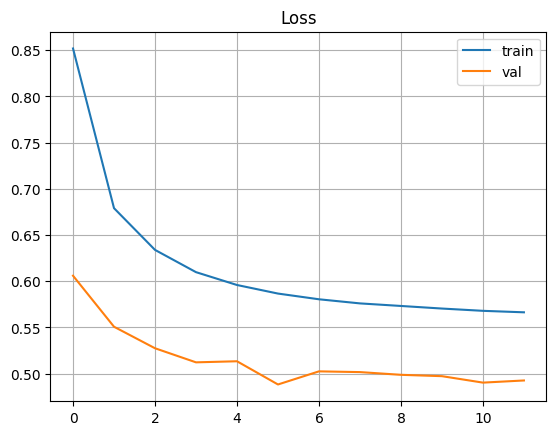

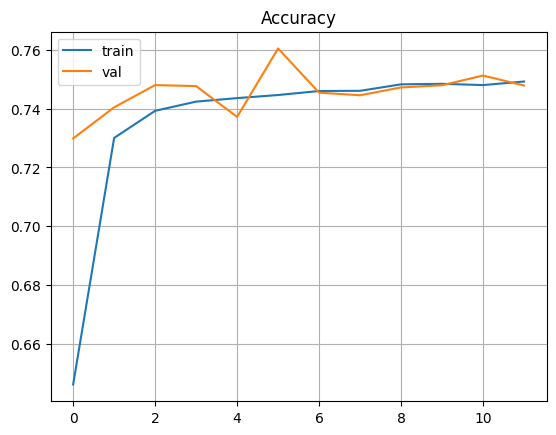

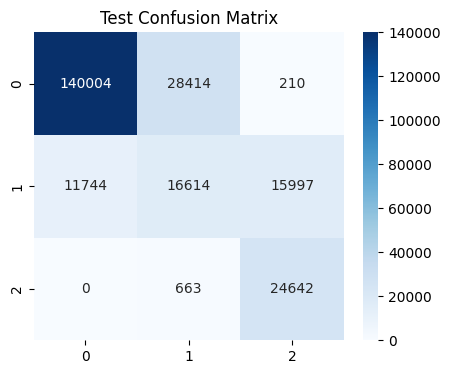

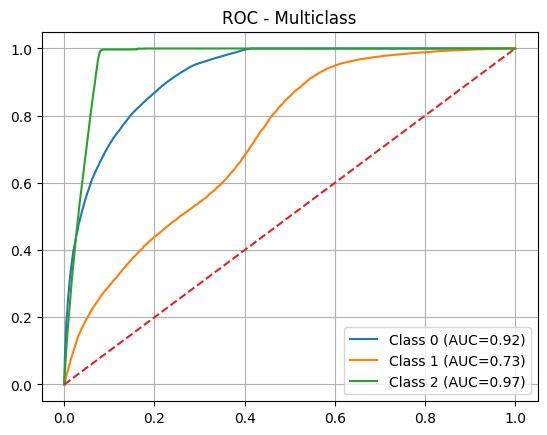

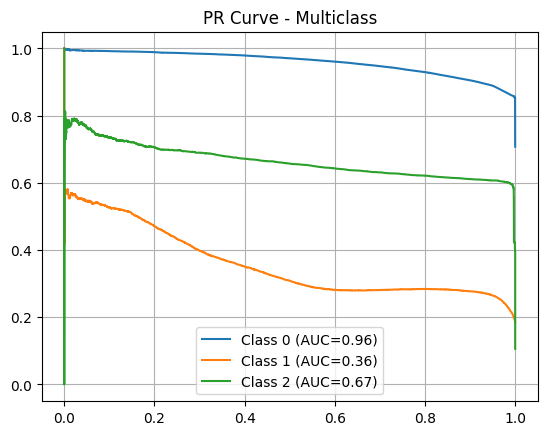

In [ ]:
# Plotes

# Training curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.legend(["train","val"])
plt.grid()
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(["train","val"])
plt.grid()
plt.show()

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_test_pred),
            annot=True, cmap='Blues', fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

for c in range(n_classes):
    y_true_bin = (y_test == c).astype(int)
    y_prob_bin = y_test_proba[:, c]

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true_bin, y_prob_bin)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'Class {c} (AUC={roc_auc:.2f})')

plt.plot([0,1],[0,1],'--')
plt.title("ROC - Multiclass")
plt.legend()
plt.grid()
plt.show()

# PR curve
for c in range(n_classes):
    y_true_bin = (y_test == c).astype(int)
    y_prob_bin = y_test_proba[:, c]

    prec, rec, _ = precision_recall_curve(y_true_bin, y_prob_bin)
    pr_auc = auc(rec, prec)

    plt.plot(rec, prec, label=f'Class {c} (AUC={pr_auc:.2f})')

plt.title("PR Curve - Multiclass")
plt.legend()
plt.grid()
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
12975/12975 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
12975/12975 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
12975/12975 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
12975/12975 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
12975/12975 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
12975/12975 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
12975/12975 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
12975/12975 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
12975/12975 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
12975/12975 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
12975/12975 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
12975/12975 ━━━━━━━━━━━━━━━━━━━━ 14s 1

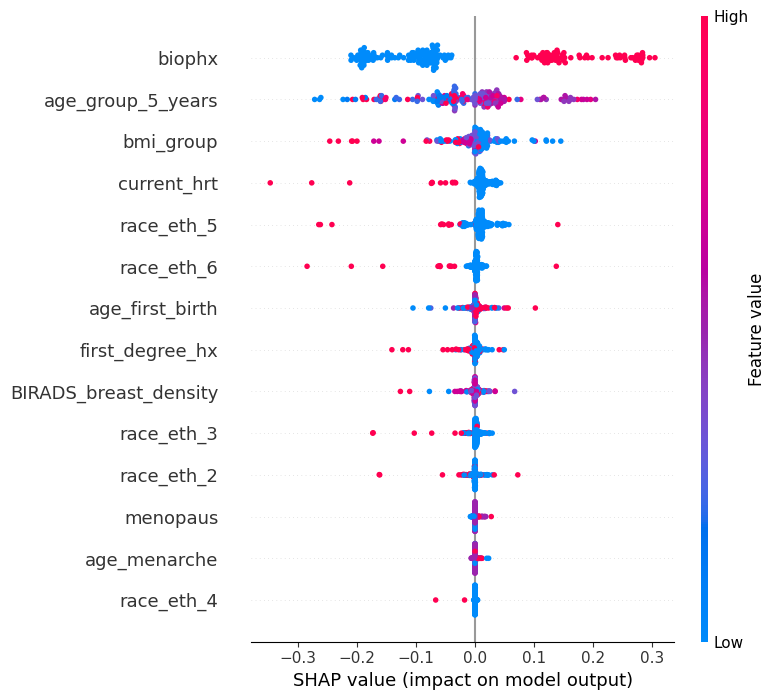

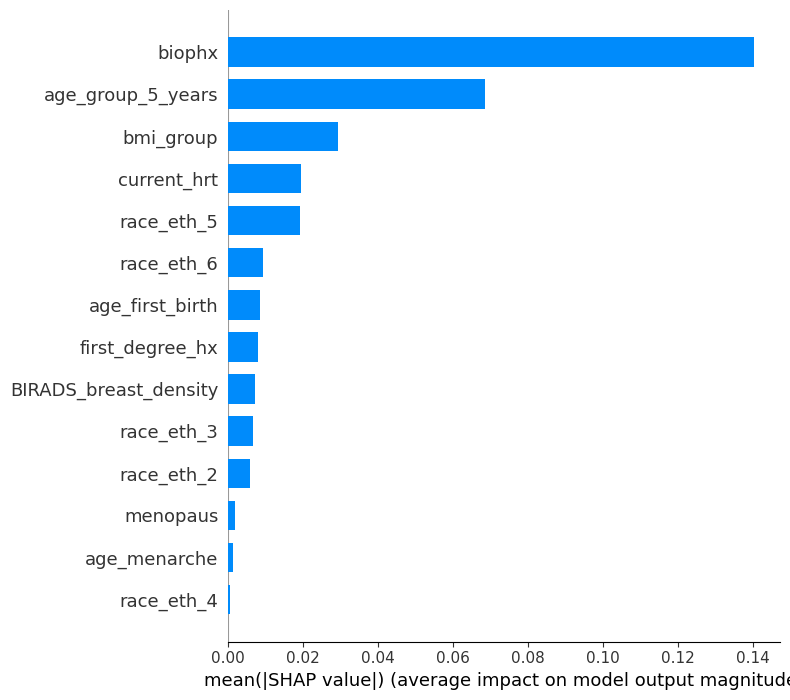

In [ ]:
# SHAP for 3-class model

background_3c = X_tr.sample(200, random_state=42)
X_val_sample_3c = X_val.sample(200, random_state=42)

explainer_3c = shap.KernelExplainer(model.predict, background_3c.values)

shap_vals_3c = explainer_3c.shap_values(X_val_sample_3c.values)

shap_vals_class2 = shap_vals_3c[:, :, 2]

# class 2 (high-risk/ borderline group)
shap.summary_plot(
    shap_vals_class2,
    X_val_sample_3c,
    feature_names=X_val_sample_3c.columns
)

# Bar
shap.summary_plot(
    shap_vals_class2,
    X_val_sample_3c,
    feature_names=X_val_sample_3c.columns,
    plot_type='bar'
)